Source 
https://github.com/chainer/chainer
https://chainer.org/

Chainer – A flexible framework of neural networks
Chainer to platforma uczenia głębokiego, obsługuje obliczenia CUDA aby wykorzystać GPU wymaga tylko kilku linijek kodu
tutaj przykładowy kod demonstrujący możliwości tego frameworka

In [ ]:
# Install Chainer and CuPy!

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 1s (16.2 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 16633 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###..

    100% |████████████████████████████████| 205.2MB 7.0kB/s 
    100% |████████████████████████████████| 81kB 2.2MB/s 
    100% |████████████████████████████████| 368kB 2.3MB/s 
  Running setup.py bdist_wheel for chainer ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/ce/20/9f/4f7d6978c1a5f88bf2bb18d429998b85cf75cfe96315c7631b
  Running setup.py bdist_wheel for filelock ... - done
  Stored in directory: /content/.cache/pip/wheels/5f/5e/8a/9f1eb481ffbfff95d5f550570c1dbeff3c1785c8383c12c62b
Successfully built chainer filelock


In [ ]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import mnist

/usr/local/lib/python3.6/dist-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


In [13]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [ ]:
train, test = mnist.get_mnist()

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

In [ ]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()

In [ ]:
max_epoch = 10

model = L.Classifier(model)

gpu_id = 0  # Set to -1 if you use CPU
if gpu_id >= 0:
    model.to_gpu(gpu_id)  # If you use CPU, comment out this line

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

In [ ]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [ ]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.560949    0.840552       0.263381              0.921578                  11.8149       
2           0.242978    0.930121       0.203952              0.937797                  15.1894       
3           0.185584    0.945879       0.159954              0.951444                  18.6129       
4           0.149979    0.956263       0.13469               0.961135                  22.0664       
5           0.126158    0.963736       0.118717              0.964992                  25.4589       
6           0.107376    0.9687         0.106752              0.967069                  28.8992       
7           0.0941283   0.973231       0.100885              0.969244                  32.3238       
8           0.0836759   0.975778       0.0935753             0.971618                  35.7101       
9           0.0738878   0.978778       0.0901924             0.9732                 

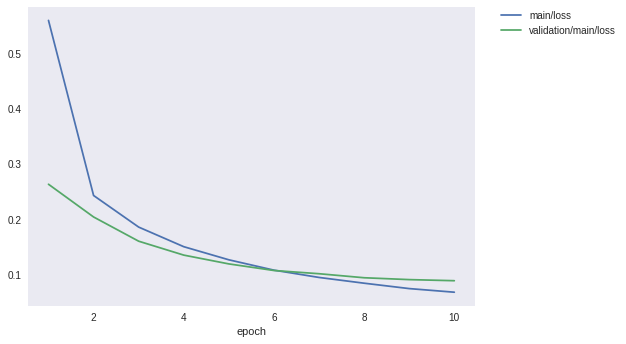

In [ ]:
from IPython.display import Image
Image('mnist_result/loss.png')

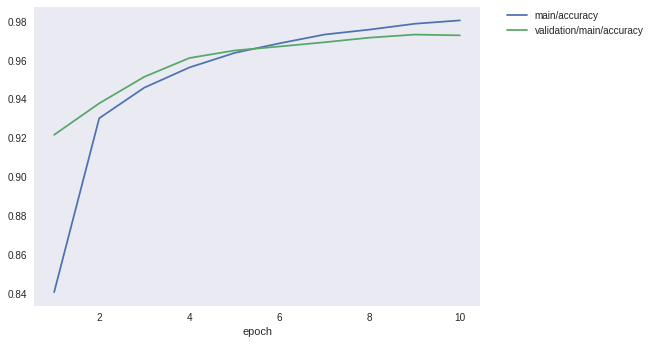

In [ ]:
Image('mnist_result/accuracy.png')